In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

* Data Load

In [100]:
ppg_signal_5 = np.load('workspace/old_data/ica_ppg_signal_5.npy') # 5 min ppg

In [107]:
ecg_signal_5 = np.load('workspace/old_data/ica_ecg_signal_5.npy') # 5 min ecg

In [102]:
ppg_lb = np.load('workspace/old_data/ica_ppg_lb.npy')

In [103]:
ecg_lb = np.load('workspace/old_data/ica_ecg_lb.npy')

In [104]:
ppg_id = np.load('workspace/old_data/ica_ppg_id.npy')

In [105]:
ecg_id = np.load('workspace/old_data/ica_ecg_id.npy')

* ppg dataframe

In [106]:
df_ppg = pd.DataFrame(list(ppg_signal_3))

In [9]:
df_ppg['caseid'] = list(ppg_id)

In [10]:
df_ppg['label'] = list(ppg_lb)

In [11]:
df_ppg = df_ppg.dropna()

* ecg dataframe

In [12]:
df_ecg = pd.DataFrame(list(ecg_signal_3))

In [13]:
df_ecg['caseid'] = list(ecg_id)

In [14]:
df_ecg['label'] = list(ecg_lb)

In [15]:
df_ecg = df_ecg.dropna()

* concat df

In [16]:
len(list(set(df_ppg['caseid'])))

193

In [17]:
len(list(set(df_ecg['caseid'])))

206

In [18]:
len(list(set(df_ppg['caseid'])&set(df_ecg['caseid'])))

193

In [19]:
in_id = list(set(df_ppg['caseid'])&set(df_ecg['caseid']))

In [20]:
df_ecg['check'] = df_ecg['caseid'].map(lambda x : x in in_id)

In [21]:
df_ecg = df_ecg[df_ecg['check'] == True]

In [22]:
df_ecg = df_ecg.dropna()

In [23]:
df_ecg = df_ecg.drop('check', axis=1)

* bandpass filtring

In [24]:
from scipy.signal import butter
from scipy.signal import lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # 50, fs:100 
    low = lowcut / nyq # 0.5/50 = 1/100, lowcut: 0.5
    high = highcut / nyq # 15/50 = 30/100, highcut : 15
    # order : frequency cut wave
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# BPF setting 0.5 ~ 15 hz
lowcut = 0.5
highcut = 15
fs = 100

In [26]:
df_ppg_bp_sig = []
for idx in range(len(df_ppg)):
    df_ppg_bp_sig.append(butter_bandpass_filter(df_ppg.iloc[idx][:-2], lowcut, highcut, fs))

In [27]:
df_ecg_bp_sig = []
for idx in range(len(df_ecg)):
    df_ecg_bp_sig.append(butter_bandpass_filter(df_ecg.iloc[idx][:-2], lowcut, highcut, fs))

* visualize

In [28]:
import matplotlib.pylab as plt

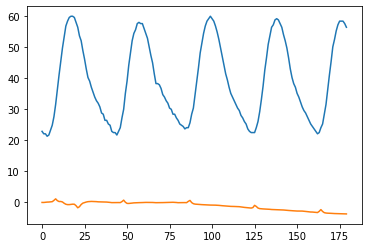

In [29]:
plt.plot(df_ppg_bp_sig[0])
plt.plot(df_ecg_bp_sig[0])

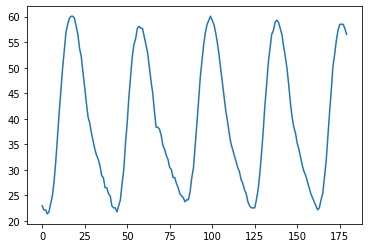

In [30]:
plt.plot(df_ppg_bp_sig[0])

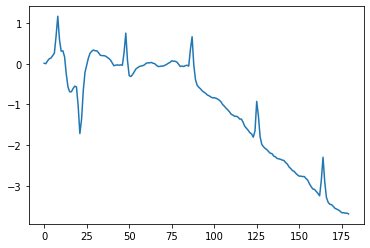

In [31]:
plt.plot(df_ecg_bp_sig[0])

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dropout, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization, ReLU, MaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import layers

In [33]:
X_train = [df_ppg_bp_sig, df_ecg_bp_sig]

In [34]:
y_train = list(df_ppg['label'].map(lambda x : 0 if x == 0 else 1))

In [35]:
X_train = np.asarray(df_ppg_bp_sig)
y_train = np.asarray(y_train)

In [36]:
len(X_train)

639

In [37]:
len(y_train)

639

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
train_data, valid_data, train_labels, valid_labels = train_test_split(
    X_train, y_train, test_size=0.3, random_state=21
)

In [40]:
valid_data, test_data, valid_labels, test_labels = train_test_split(
    valid_data, valid_labels, test_size=0.5, random_state=21
)

In [41]:
# minmaxnormalization
min_tr = tf.reduce_min(np.float32(train_data))
# max
max_tr = tf.reduce_max(np.float32(train_data))
# min
min_val = tf.reduce_min(np.float32(valid_data))
# min
max_val = tf.reduce_max(np.float32(valid_data))

min_te = tf.reduce_min(np.float32(test_data))
# min
max_te = tf.reduce_max(np.float32(test_data))

2022-11-23 08:52:45.657182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 08:52:45.660764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 08:52:45.660839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-23 08:52:45.661394: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [42]:
train_data = (train_data - min_tr) / (max_tr - min_tr)
valid_data = (valid_data - min_val) / (max_val - min_val)
test_data = (test_data - min_te) / (max_te - min_te)

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [43]:
len(train_data), len(valid_data)

(447, 96)

In [44]:
len(valid_data), len(test_data)

(96, 96)

In [45]:
list(train_labels).count(1)

149

In [46]:
list(train_labels).count(0)

298

* model1

In [84]:
model = Sequential()
# conv1
model.add(Conv1D(64, 16, padding='valid', strides=1,input_shape=(180, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv2
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv3
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv4
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv5
model.add(Conv1D(64, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv6
model.add(Conv1D(32, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv6
model.add(Conv1D(32, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())
model.add(Dense(320))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 165, 64)           1088      
                                                                 
 batch_normalization_14 (Bat  (None, 165, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_14 (ReLU)             (None, 165, 64)           0         
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 82, 64)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 82, 64)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 82, 128)          

In [86]:
from sklearn.utils import class_weight

In [87]:
weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(train_labels),
                                            y = train_labels)

In [88]:
weights = {i : weights[i] for i in range(2)}
weights

{0: 0.75, 1: 1.5}

In [95]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.3)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [96]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [97]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [98]:
history = model.fit(train_data, train_labels, batch_size = 32, epochs=500, validation_data=(test_data, test_labels), class_weight={i:weights[i] for i in range(len(weights))})

Epoch 1/500
14/14 [==============================] - 1s 13ms/step - loss: 0.7024 - acc: 0.5526 - val_loss: 0.6606 - val_acc: 0.7083
Epoch 2/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7352 - acc: 0.5213 - val_loss: 0.6611 - val_acc: 0.7083
Epoch 3/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7239 - acc: 0.5056 - val_loss: 0.6617 - val_acc: 0.7083
Epoch 4/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7239 - acc: 0.5101 - val_loss: 0.6606 - val_acc: 0.7188
Epoch 5/500
14/14 [==============================] - 0s 6ms/step - loss: 0.7423 - acc: 0.5101 - val_loss: 0.6593 - val_acc: 0.7292
Epoch 6/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7022 - acc: 0.5593 - val_loss: 0.6596 - val_acc: 0.7292
Epoch 7/500
14/14 [==============================] - 0s 5ms/step - loss: 0.7412 - acc: 0.4855 - val_loss: 0.6597 - val_acc: 0.7292
Epoch 8/500
14/14 [==============================] - 0s 6ms/step - loss: 0.7259 - 

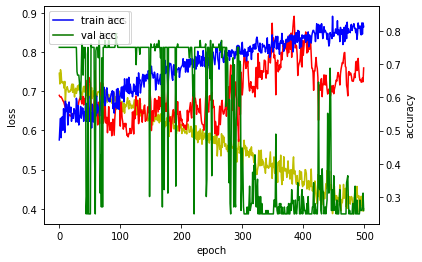

In [89]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

* model2

In [106]:
model = Sequential()
# conv1
model.add(Conv1D(64, 10, padding='valid', strides=1,input_shape=(300, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv2
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv3
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())
model.add(Dense(320))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [107]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 291, 64)           704       
                                                                 
 batch_normalization_24 (Bat  (None, 291, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_24 (ReLU)             (None, 291, 64)           0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 145, 64)          0         
 g1D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 145, 64)           0         
                                                                 
 conv1d_25 (Conv1D)          (None, 145, 128)         

In [108]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [109]:
history = model.fit(train_data, train_labels, epochs=500, validation_data=(test_data, test_labels))

Epoch 1/500
14/14 [==============================] - 1s 9ms/step - loss: 1.4544 - acc: 0.6031 - val_loss: 0.6520 - val_acc: 0.7708
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 1.0974 - acc: 0.6054 - val_loss: 0.6275 - val_acc: 0.7708
Epoch 3/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8705 - acc: 0.6009 - val_loss: 0.6533 - val_acc: 0.7708
Epoch 4/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8699 - acc: 0.6166 - val_loss: 0.5697 - val_acc: 0.7708
Epoch 5/500
14/14 [==============================] - 0s 3ms/step - loss: 0.9585 - acc: 0.6188 - val_loss: 0.6345 - val_acc: 0.7708
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8808 - acc: 0.5987 - val_loss: 0.5747 - val_acc: 0.7708
Epoch 7/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7188 - acc: 0.6502 - val_loss: 0.5879 - val_acc: 0.7708
Epoch 8/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7203 - a

: 

* model3

In [182]:
model = Sequential()
# conv1
model.add(Conv1D(64, 10, padding='valid', strides=1,input_shape=(60, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))

# conv2
model.add(Conv1D(128, 16, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPool1D(2,strides=2))
model.add(Dropout(0.3))


model.add(GlobalMaxPooling1D())
model.add(Dense(320))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [183]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [184]:
history = model.fit(train_data, train_labels, epochs=500, validation_data=(test_data, test_labels))

Epoch 1/500
14/14 [==============================] - 0s 9ms/step - loss: 1.0419 - acc: 0.6085 - val_loss: 0.7079 - val_acc: 0.7708
Epoch 2/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8310 - acc: 0.6130 - val_loss: 0.5932 - val_acc: 0.7188
Epoch 3/500
14/14 [==============================] - 0s 2ms/step - loss: 0.8935 - acc: 0.5884 - val_loss: 0.7488 - val_acc: 0.7500
Epoch 4/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8723 - acc: 0.5548 - val_loss: 0.7650 - val_acc: 0.7500
Epoch 5/500
14/14 [==============================] - 0s 3ms/step - loss: 0.8685 - acc: 0.6398 - val_loss: 0.6324 - val_acc: 0.6667
Epoch 6/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7728 - acc: 0.5906 - val_loss: 0.6829 - val_acc: 0.7604
Epoch 7/500
14/14 [==============================] - 0s 3ms/step - loss: 0.7689 - acc: 0.5996 - val_loss: 0.6687 - val_acc: 0.6354
Epoch 8/500
14/14 [==============================] - 0s 2ms/step - loss: 0.7594 - a